<a href="https://colab.research.google.com/github/richardtekere09/Machine_Learning_labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries Check if the model is. running on. GPU


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.17.1
GPU is available



Load My Image and Manual Annotation


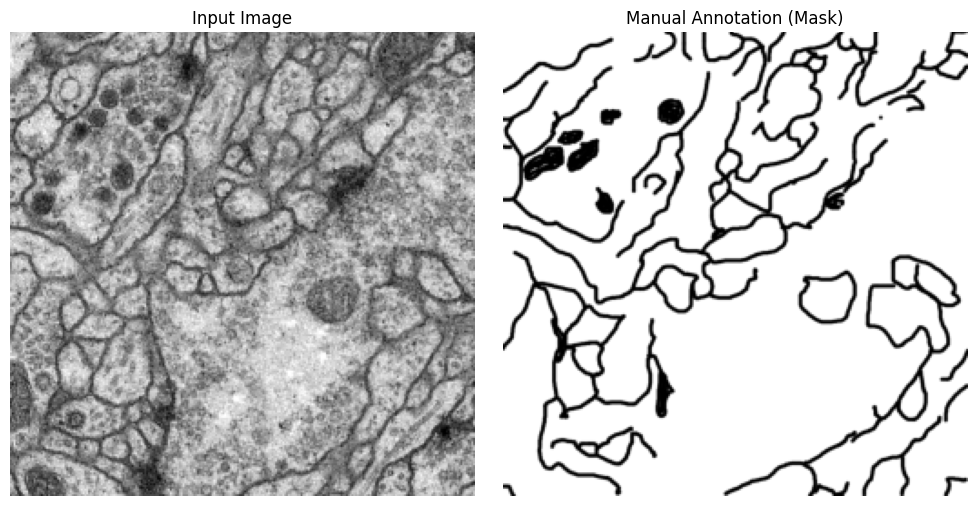

In [ ]:
my_image_path = "/content/drive/MyDrive/membrane/test/image/0.png"
my_mask_path ="/content/drive/MyDrive/membrane/test/mask/mask_1.png"

# Load and preprocess the image
input_image = imread(my_image_path, as_gray=True)
input_image_resized = resize(input_image, (256, 256), anti_aliasing=True)
input_image_normalized = input_image_resized[..., np.newaxis] / 255.0

# Load and preprocess the manual annotation
manual_mask = imread(my_mask_path, as_gray=True)
manual_mask_resized = resize(manual_mask, (256, 256), anti_aliasing=True)
manual_mask_normalized = manual_mask_resized[..., np.newaxis] / 255.0
manual_mask_binary = (manual_mask_resized > 0.5).astype(np.float32)

# Visualize the image and its manual annotation
plt.figure(figsize=(10, 5))

# Display the input image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image_resized, cmap="gray")
plt.axis("off")

# Display the manual annotation
plt.subplot(1, 2, 2)
plt.title("Manual Annotation (Mask)")
plt.imshow(manual_mask_resized, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

Load and Preprocess Training Dataset

Train Images Shape: (24, 256, 256, 1)
Train Masks Shape: (24, 256, 256, 1)
Test Images Shape: (6, 256, 256, 1)
Test Masks Shape: (6, 256, 256, 1)


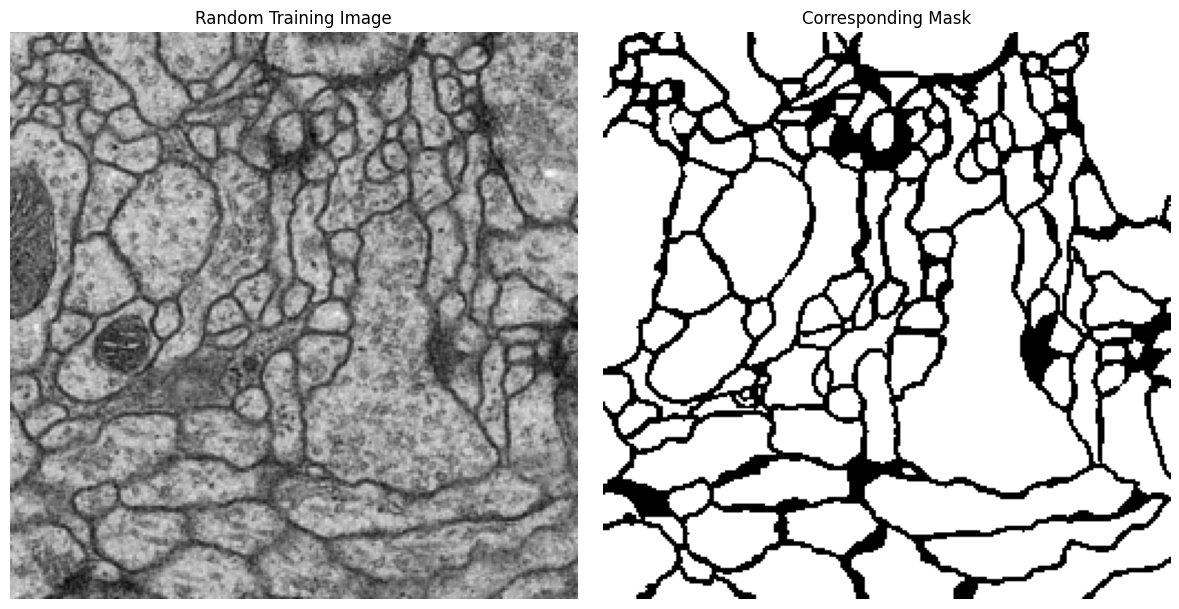

In [ ]:
def load_images(path, size=(256, 256)):
    images = []
    masks = []

    img_path = os.path.join(path, "image")
    mask_path = os.path.join(path, "mask")

    for file in sorted(os.listdir(img_path)):
        if file.endswith(".png") and not file.startswith("."):  # Adjust to match dataset format
            img = imread(os.path.join(img_path, file), as_gray=True)
            img_resized = resize(img, size, anti_aliasing=True)
            images.append(img_resized)

    for file in sorted(os.listdir(mask_path)):
        if file.endswith(".png") and not file.startswith("."):  # Adjust to match dataset format
            mask = imread(os.path.join(mask_path, file), as_gray=True)
            mask_resized = resize(mask, size, anti_aliasing=True)
            mask_binary = (mask_resized > 0.5).astype(np.float32)
            masks.append(mask_binary)

    return np.array(images)[..., np.newaxis], np.array(masks)[..., np.newaxis]

# Paths to dataset
data_path = "/content/drive/MyDrive/membrane/train"

# Load the data
images, masks = load_images(data_path)


# Split into training and test data
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)
# Debug: Print shapes
print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Test Images Shape:", val_images.shape)
print("Test Masks Shape:", val_masks.shape)

# Select a random index
random_index = np.random.randint(0, len(train_images))

# Get the random image and mask
random_image = train_images[random_index, ..., 0]  # Assuming grayscale image
random_mask = train_masks[random_index, ..., 0]   # Assuming grayscale mask

# Visualize the random image and mask
plt.figure(figsize=(12, 6))

# Display the random training image
plt.subplot(1, 2, 1)
plt.title("Random Training Image")
plt.imshow(random_image, cmap="gray")
plt.axis("off")

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.title("Corresponding Mask")
plt.imshow(random_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

U-Net Model

In [ ]:
def combined_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    dice_loss = 1 - dice

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.7 * dice_loss + 0.3 * tf.reduce_mean(bce)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.7 * dice_loss + 0.3 * tf.reduce_mean(bce)

def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, 1, padding='same')(x)
    phi_g = layers.Conv2D(filters, 1, padding='same')(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, 1, padding='same')(f)
    return layers.multiply([x, layers.Activation('sigmoid')(psi_f)])

def build_improved_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inputs)

    def conv_block(x, filters, dropout_rate=0.0):
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout2D(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    # Encoder
    c1 = conv_block(x, 64, 0.1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128, 0.1)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256, 0.2)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 512, 0.2)
    p4 = layers.MaxPooling2D()(c4)

    # Bridge
    bridge = conv_block(p4, 1024, 0.3)

    # Decoder
    def up_block(x, skip, filters, dropout_rate=0.0):
        x = layers.UpSampling2D()(x)
        att_skip = attention_gate(skip, x, filters)
        x = layers.Concatenate()([x, att_skip])
        return conv_block(x, filters, dropout_rate)

    u6 = up_block(bridge, c4, 512, 0.2)
    u7 = up_block(u6, c3, 256, 0.2)
    u8 = up_block(u7, c2, 128, 0.1)
    u9 = up_block(u8, c1, 64, 0.1)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(u9)
    residual = layers.Conv2D(1, 1, padding='same')(inputs)
    outputs = layers.Add()([outputs, residual])
    outputs = layers.Activation('sigmoid')(outputs)

    return models.Model(inputs, outputs)

# Build the improved model
model = build_improved_unet()
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=combined_loss,
    metrics=['accuracy', MeanIoU(num_classes=2)]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 256, 1)    │              2 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ activation[0][0]       │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 128, 128, 128)  │              0 │ activation_2[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ spatial_dropout2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 32,448,713 (123.78 MB)

 Trainable params: 32,436,937 (123.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

Data Generator and Training

In [ ]:
def create_data_generator(images, masks, batch_size=8):  # Increased batch size
    while True:
        idx = np.random.randint(0, images.shape[0], batch_size)
        batch_images = images[idx].copy()
        batch_masks = masks[idx].copy()

        for i in range(batch_size):
            if np.random.rand() > 0.5:
                batch_images[i] = np.fliplr(batch_images[i])
                batch_masks[i] = np.fliplr(batch_masks[i])
            if np.random.rand() > 0.5:
                batch_images[i] = np.flipud(batch_images[i])
                batch_masks[i] = np.flipud(batch_masks[i])

            k = np.random.randint(0, 4)
            batch_images[i] = np.rot90(batch_images[i], k)
            batch_masks[i] = np.rot90(batch_masks[i], k)

            factor = np.random.uniform(0.8, 1.2)
            batch_images[i] = np.clip(batch_images[i] * factor, 0, 1)

        yield batch_images, batch_masks

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1
    )
]

train_gen = create_data_generator(train_images, train_masks, batch_size=16)
val_gen = create_data_generator(val_images, val_masks, batch_size=16)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // 8,
    validation_data=val_gen,
    validation_steps=len(val_images) // 8,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7704 - loss: 0.3886 - mean_io_u: 0.1148

Evaluation and Visualization

In [ ]:
def evaluate_prediction(model, image_path, mask_path):
    predicted_mask = model.predict(input_image_normalized[np.newaxis, ...])[0, ..., 0]
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.float32)

    dice_score = 2 * np.sum(predicted_mask_binary * manual_mask_binary) / (
        np.sum(predicted_mask_binary) + np.sum(manual_mask_binary)
    )
    iou_score = np.sum(predicted_mask_binary * manual_mask_binary) / (
        np.sum((predicted_mask_binary + manual_mask_binary) > 0)
    )

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(input_image_resized, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(manual_mask_binary, cmap='gray')
    axes[1].set_title('Manual Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    overlay = np.zeros((*input_image_resized.shape, 3))
    overlay[..., 0] = input_image_resized
    overlay[..., 1] = input_image_resized
    overlay[..., 2] = input_image_resized
    overlay[predicted_mask > 0.5] = [1, 0, 0]

    axes[3].imshow(overlay)
    axes[3].set_title('Overlay')
    axes[3].axis('off')

    plt.suptitle(f'Dice Score: {dice_score:.3f}, IoU Score: {iou_score:.3f}')
    plt.tight_layout()
    plt.show()

    return dice_score, iou_score

# Evaluate test image
dice_score, iou_score = evaluate_prediction(model, test_image_path, test_mask_path)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()